<a href="https://colab.research.google.com/github/yoii18/KaggleModels/blob/main/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'intel-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F111880%2F269359%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240211%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240211T180846Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D49bd2c48c7169c9b4024d985005394f50058a5993a0e60b0f3efe7f7982b29516ad1ef7976eee39d184fb920968278dba8fbbc1ec9e1c7919882a209fb3cfaae876bdb6f5a443ee36bb325607a6afe70f8cb0fcab3a0a38b68ecda583b61ae12f1fa77a3bc72e38acbd95fbcb1be7a3f4ef277e3e19f76864cb066f7cb24ef7c526af2ef04238f6614244050d394a19f526acf563a9d632fd525d044626c94e08f67310d4574f8456c674489ac9bfd992d167c50edc44cbe5e78614af01e73a501c92e51018b8384f560cb91cf0dfeb5ae537f127e0f74e4a28f2459aaf972c88679d01bc9bd947ba1a623eee1c30826f0a0331c5765caf48854fb02d9f26e89'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 363152213 bytes downloaded
Downloaded and uncompressed: intel-image-classification
Data source import complete.


In [18]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.optim as optim
from PIL import Image
from torchvision import models
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_labels = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150,150)

class_names_labels.values()

dict_values([0, 1, 2, 3, 4, 5])

In [5]:
dataset = ImageFolder('/kaggle/input/intel-image-classification/seg_train/seg_train')
test = ImageFolder('/kaggle/input/intel-image-classification/seg_test/seg_test')
train_data, train_label = dataset.imgs, dataset.targets
test_data, test_label = test.imgs, test.targets

In [6]:
from collections import Counter
print(dict(Counter(dataset.targets)))

{0: 2191, 1: 2271, 2: 2404, 3: 2512, 4: 2274, 5: 2382}


In [7]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.check_channel(dataset)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        class_category = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, class_category

    def check_channel(self, dataset):
        datasetRGB = []
        for idx in range(len(dataset)):
            if (Image.open(dataset[idx][0]).getbands() == ('R', 'G', 'B')):
                datasetRGB.append(dataset[idx])
        return datasetRGB


In [8]:
transforms.functional.get_image_size(Image.open(dataset.imgs[1][0]))

[150, 150]

In [9]:
train_transform = v2.Compose([
                v2.Resize((150,150)),
                v2.RandomHorizontalFlip(p=0.5), # randomly flip and rotate
                v2.ColorJitter(0.3,0.4,0.4,0.2),
                v2.ToTensor(),
                v2.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])

test_transform = v2.Compose([
                v2.Resize((150,150)),
                v2.ToTensor(),
                v2.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [10]:
train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)

In [19]:
valid_size = 0.15
# Splot data into train and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [20]:
train_loader = DataLoader(train_dataset,batch_size=50,sampler=train_sampler,num_workers=2)
valid_loader = DataLoader(train_dataset, batch_size =100, sampler=valid_sampler, num_workers=3)
test_loader= DataLoader(test_dataset,batch_size=32,shuffle=False,num_workers=2)

In [12]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


In [13]:
for param in model.parameters():
    param.req_grads = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6], gamma=0.06)

In [21]:
# number of epochs for training set
epochs = 7

# track change in validation loss
valid_loss_min = np.Inf
val_loss = []
tn_loss = []
for epoch in range(1,epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Train the model
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensor to gpu if cuda is available
        data, target = data.to(device), target.to(device)
        # clear the gradiant of all optimizer variable
        optimizer.zero_grad()
        # forward pass: compute pradictions by passing inputs
        output = model(data)
        # calculate batch loss
        loss = criterion(output, target)
        # backward pass: compute gradiant of the loss with respect to the parameters
        loss.backward()
        # update parameters by optimizing single step
        optimizer.step()

        # update training loss
        train_loss += loss.item()*data.size(0)

    # validate the model

    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensor to gpu
        data, target = data.to(device), target.to(device)
        # forward pass: compute the validation predictions
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update the validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average loss
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    val_loss.append(valid_loss)
    tn_loss.append(train_loss)
    # update learning rate
    scheduler.step()
    # Print the train and validation loss statistic
    print('Epoch: {} \t Training Loss: {:.3f} \t Validation Loss: {:.3f}'.format(epoch, train_loss, valid_loss))

    # save model if validation loss decrease
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased {:.4f}--->{:.4f}  Saving model...".format(valid_loss_min, valid_loss))
        # save current model
        torch.save(model.state_dict(), 'model_state.pt')
        valid_loss_min = valid_loss
    print('Learning Rate ------------->{:.4f}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

Epoch: 1 	 Training Loss: 0.085 	 Validation Loss: 0.055
Validation loss decreased inf--->0.0551  Saving model...
Learning Rate ------------->0.0004
Epoch: 2 	 Training Loss: 0.083 	 Validation Loss: 0.057
Learning Rate ------------->0.0004
Epoch: 3 	 Training Loss: 0.084 	 Validation Loss: 0.061
Learning Rate ------------->0.0004
Epoch: 4 	 Training Loss: 0.083 	 Validation Loss: 0.059
Learning Rate ------------->0.0004
Epoch: 5 	 Training Loss: 0.085 	 Validation Loss: 0.060
Learning Rate ------------->0.0004
Epoch: 6 	 Training Loss: 0.084 	 Validation Loss: 0.057
Learning Rate ------------->0.0004
Epoch: 7 	 Training Loss: 0.081 	 Validation Loss: 0.057
Learning Rate ------------->0.0004


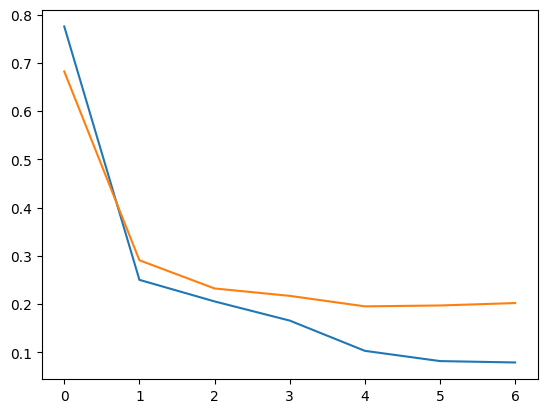

In [17]:
plt.plot(tn_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

In [ ]:
correct_count, all_count = 0, 0
for images